In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dask_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
# sys.path.append("../../")
print(sys.executable)
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler='threads')
import xarray as xr

# from python.misc.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
# from python.misc.plot import plot_multif_prediction

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.svm import SVR

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

/usr/bin/python3


# Util Functions Defined Here:

In [ ]:
def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.

    Parameters
    ----------
    vector : numpy.array
    time   : xr.DataArray
    name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)
  
def generate_prediction_array(y_pred, y_reana, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.

    Parameters
    ----------
    y_pred          : xr.DataArray
    y_reana         : xr.DataArray
    forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:, 0] = y_reana.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)

    pred_multif = xr.DataArray(pred_multif_data_fin,
                       coords={'num_of_forecast': range(1, num_forecasts+1),
                               'forecast_day': range(0, forecast_range+1),
                               'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                       dims=['num_of_forecast', 'forecast_day'],
                       name='prediction')
    return pred_multif

def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.

    Parameters
    ----------
    x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

def plot_multif_prediction(pred_multif, y_reana, forecast_range=14, title=None):
    """Convenience function for plotting multiforecast shaped prediction and reanalysis.

    Note when using the returned 'ax' variable to plot additional lines outside of
    the function the corresponding objects need to be pd.Series (xr.DataArray objects
    will not be plotted onto the axis)!

    Parameters
    ----------
        pred_multif     : xr.DataArray
        y_reana         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    y_reana.sel({'time': pred_multif.time.values.ravel()}
                ).to_pandas().plot(ax=ax, label='GloFAS Reanalysis')

    pdseries = pd.Series(data=pred_multif.sel(num_of_forecast=1).values,
                         index=pred_multif.sel(num_of_forecast=1).time.values)
    pdseries.plot(ax=ax, label='Model')
    plt.legend()
    for i in pred_multif.num_of_forecast[1:]:
        fcst = pd.Series(data=pred_multif.sel(num_of_forecast=i).values,
                         index=pred_multif.sel(num_of_forecast=i).time.values)
        fcst.plot(ax=ax)

    ax.set_ylabel('river discharge [m$^3$/s]')

    y_o = y_reana.loc[{'time': pred_multif.time.values.ravel()}].values
    y_m = pred_multif.values.ravel()

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

    plt.title(f"{title} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)} |")
    return fig, ax

# Routine:

In [ ]:
# load data
features = xr.open_dataset('/content/drive/MyDrive/499A/Dataset/features_xy.nc')
y = features['dis']
X = features.drop(['dis', 'dis_diff'])

In [ ]:
features

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables: (12/18)
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    ...          ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

In [ ]:
dis_shift_switch = False

In [ ]:
abs_vals_switch = False

In [ ]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [ ]:
X_base = X.to_array(dim='features').T.copy()
y_base = y.copy()

In [ ]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [ ]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [ ]:
X_train.shape, y_train.shape

((9131, 16), (9131,))

In [ ]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

In [ ]:
from sklearn.linear_model import Ridge
pipe = Ridge(alpha = 0.1, normalize=True)

In [ ]:
x_fit = Xda.copy()
y_fit = yda.copy()
pipe.fit(x_fit, y_fit)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


Ridge(alpha=0.1, normalize=True)

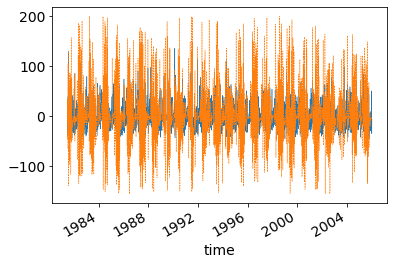

In [ ]:
Xda_insample = Xda.copy()
insample_check = pipe.predict(Xda_insample)
insample_check = add_time(insample_check, Xda_insample.index, name='forecast')
insample_check.where(insample_check > insample_check.quantile(0.01)).to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

In [ ]:

n = 1
X_pred = X_valid[::n].copy()
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)

<xarray.DataArray 'forecast' (time: 2191)>
array([  8.655235 ,  -8.797806 ,   4.9161377, ..., -30.379074 ,
       -44.007656 , -19.303596 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2011-12-31


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  "X does not have valid feature names, but"


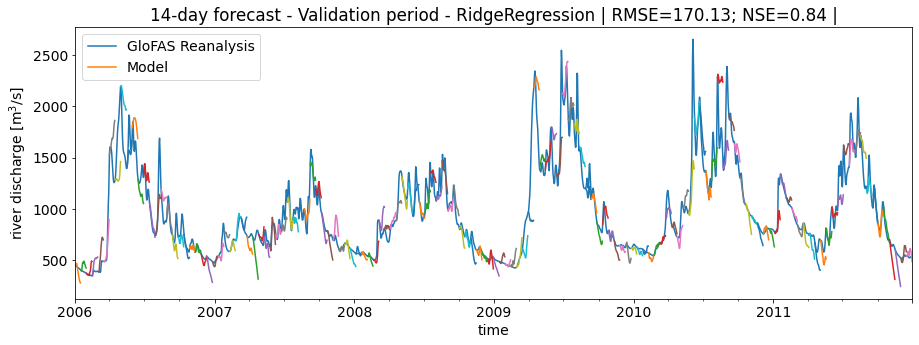

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
multif = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif, y, forecast_range=14, title='14-day forecast - Validation period - RidgeRegression');
plt.savefig('validation_period_svr.png', dpi=600, bbox_inches='tight')

In [ ]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=210.1; NSE=0.75


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  "X does not have valid feature names, but"


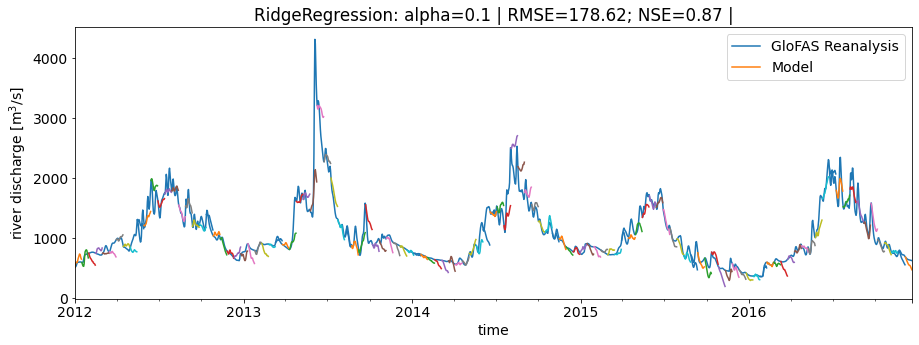

In [ ]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_test[::n].copy()
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

multif_test = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif_test, y, forecast_range=14, title='RidgeRegression: alpha=0.1');